In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import factorial
from scipy.optimize import minimize
from tqdm import tqdm
import starry
print(starry.__version__)
import earthshine

1.0.0.dev0


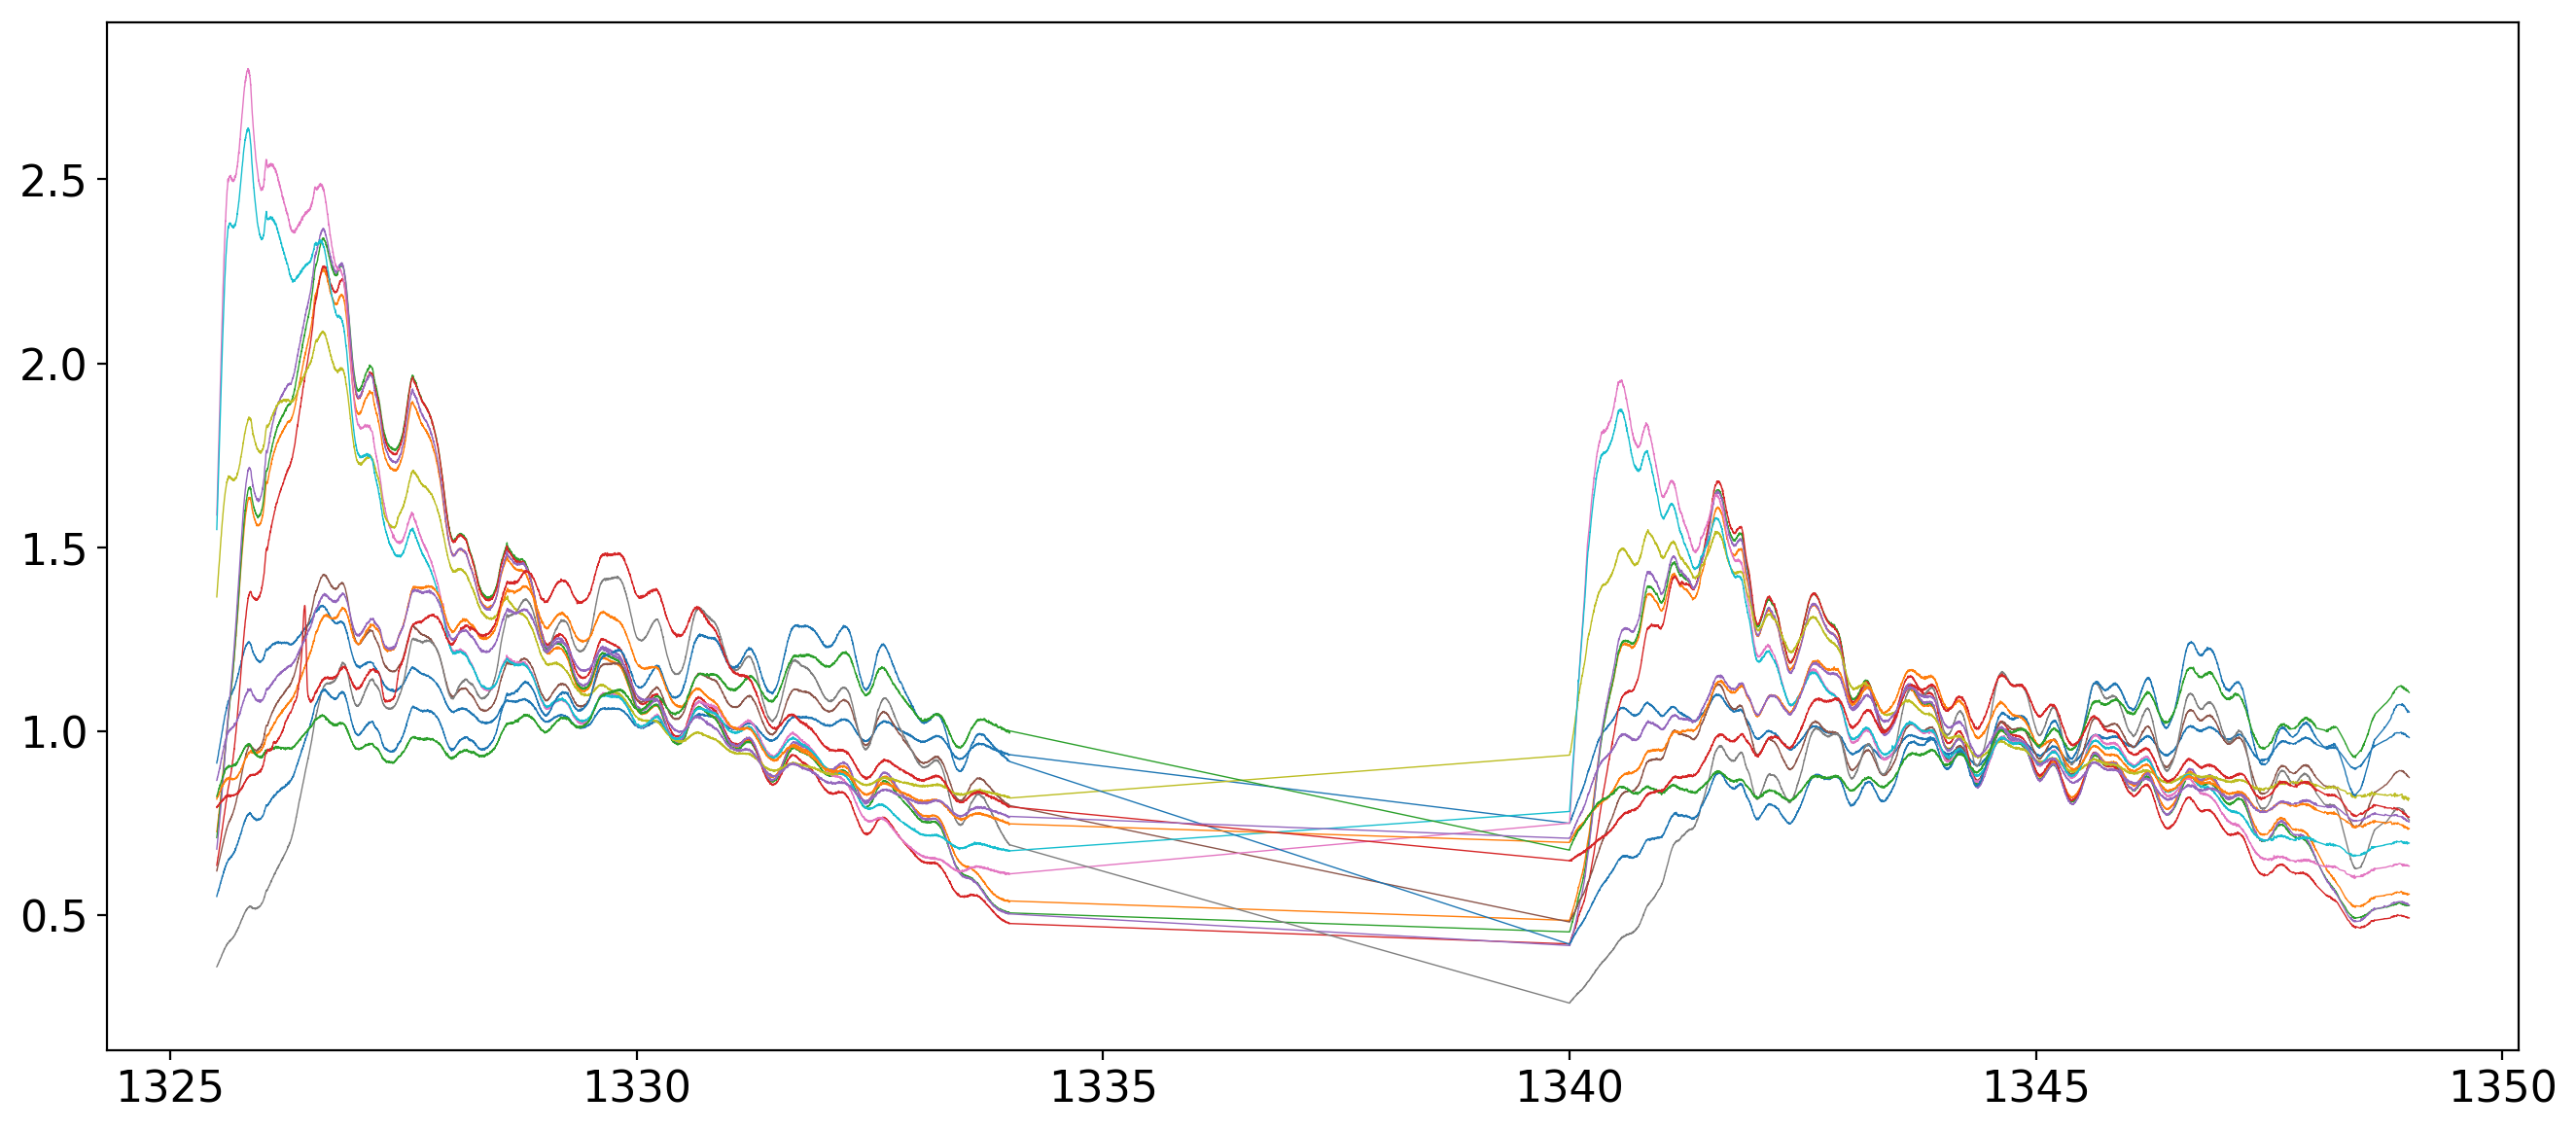

In [4]:
# Load the data for sector 1
data = np.load("../data/sector01-data.npz")
time = data["time"]
flux = data["flux"][:25]
flux_err = data["flux_err"][:25]

# Plot it
fig, ax = plt.subplots(1, figsize=(16, 7))
for f in flux:
    ax.plot(time, f, lw=0.5)

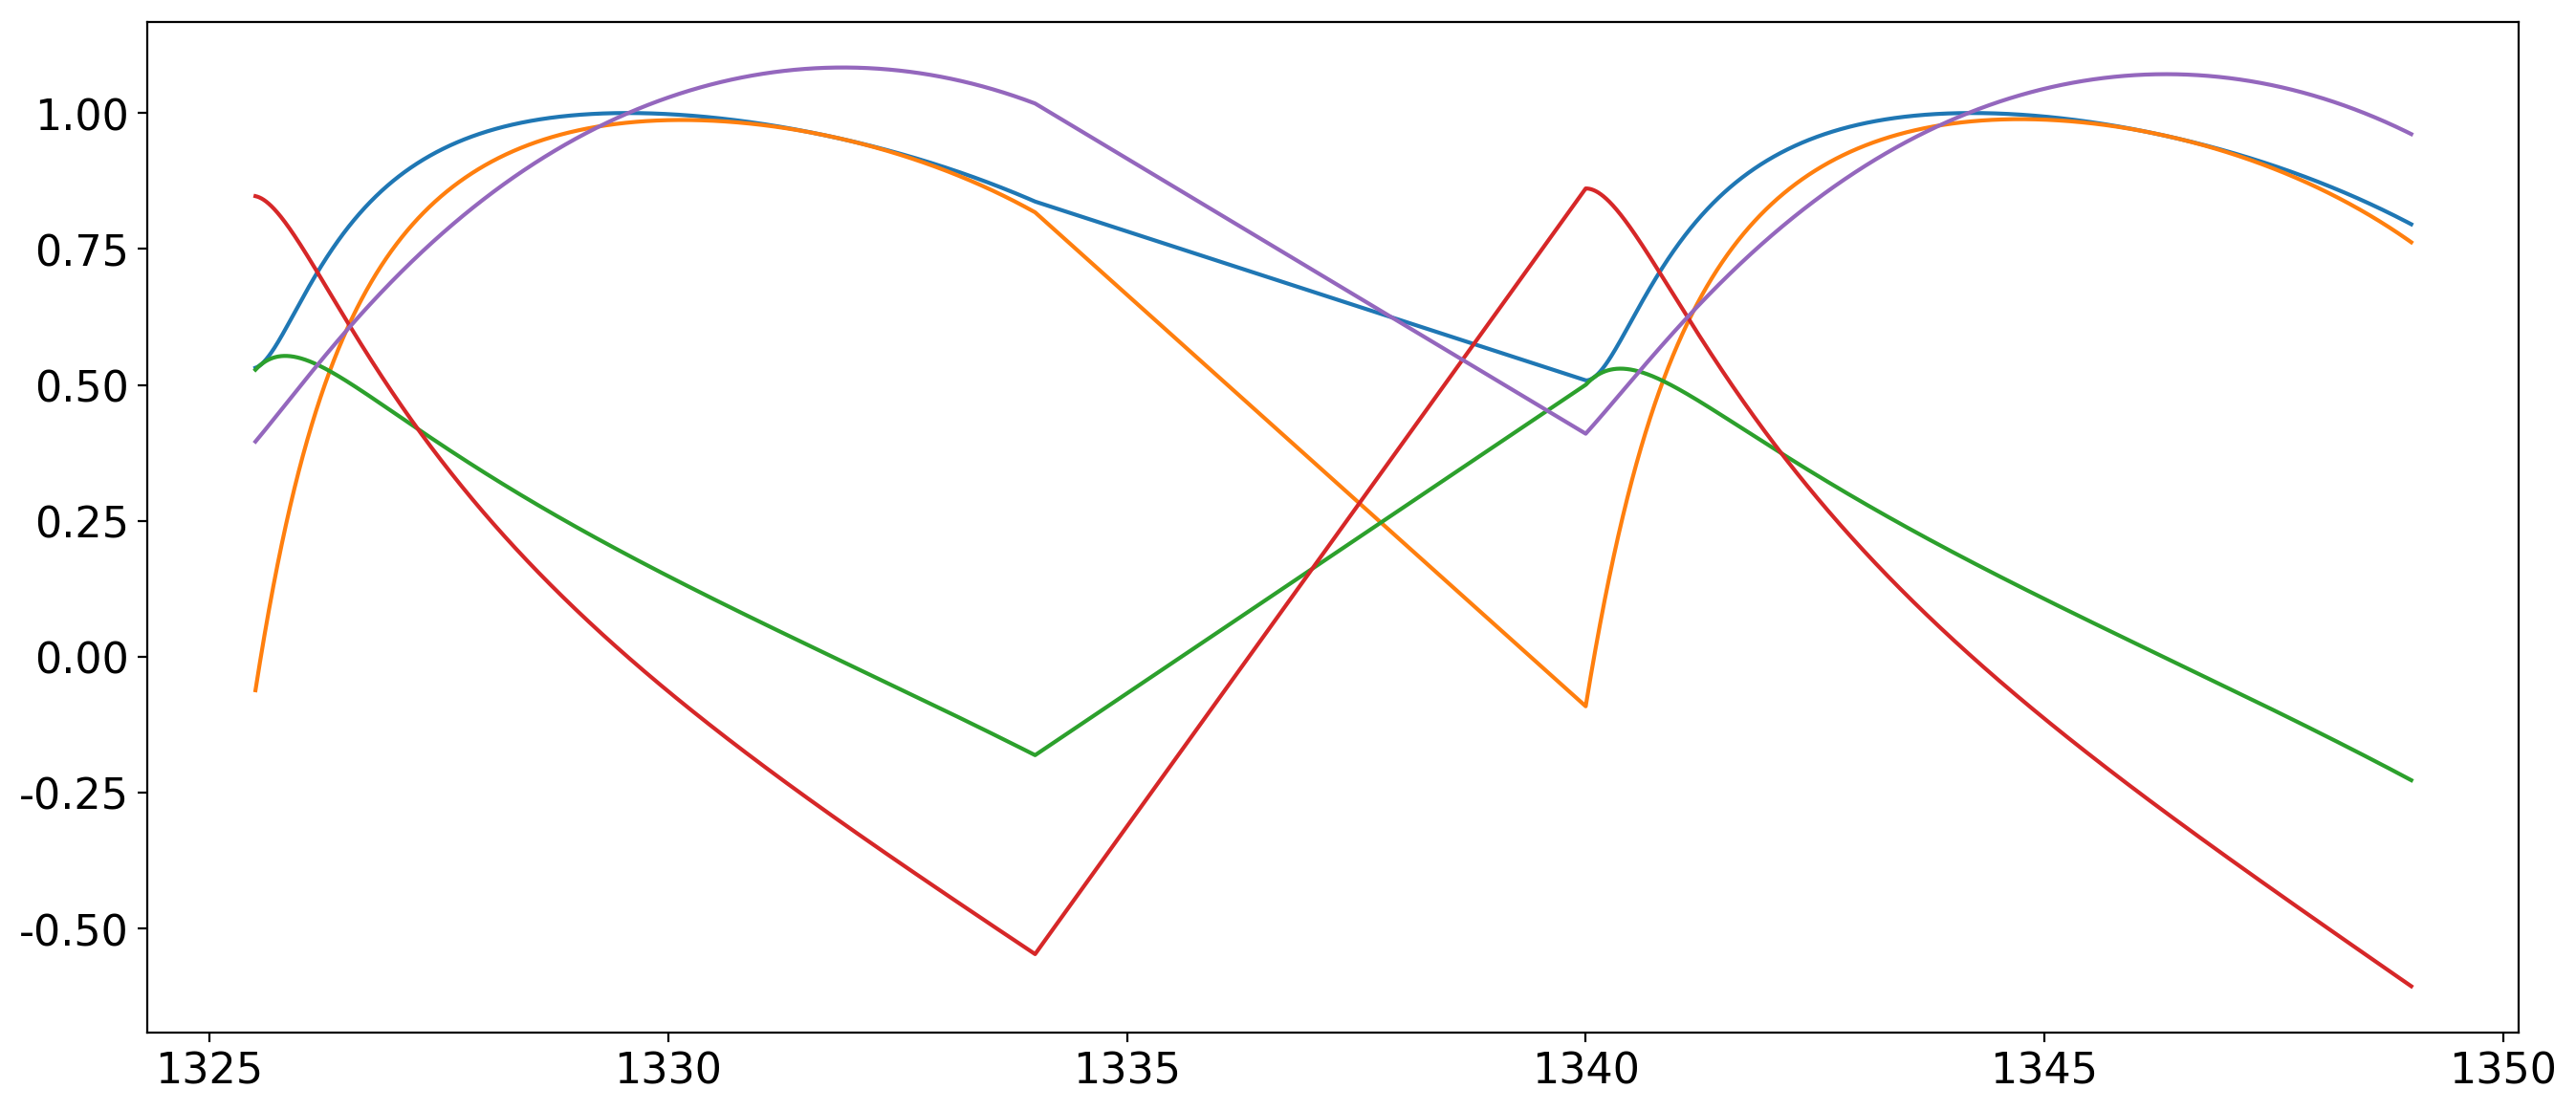

In [5]:
# Load the TESS position relative to Earth;
# we'll use this as a regressor
tvec = earthshine.tess_earth_vector(time)
tx = tvec[0]
ty = tvec[1]
tz = tvec[2]
tr = np.sqrt(tx ** 2 + ty ** 2 + tz ** 2)
tx /= tr
ty /= tr
tz /= tr
tr /= np.nanmedian(tr)

# Plot it
fig, ax = plt.subplots(1, figsize=(16, 7))
ax.plot(time, np.sqrt(tx ** 2 + ty ** 2))
ax.plot(time, tx)
ax.plot(time, ty)
ax.plot(time, tz)
ax.plot(time, tr);

# Inference

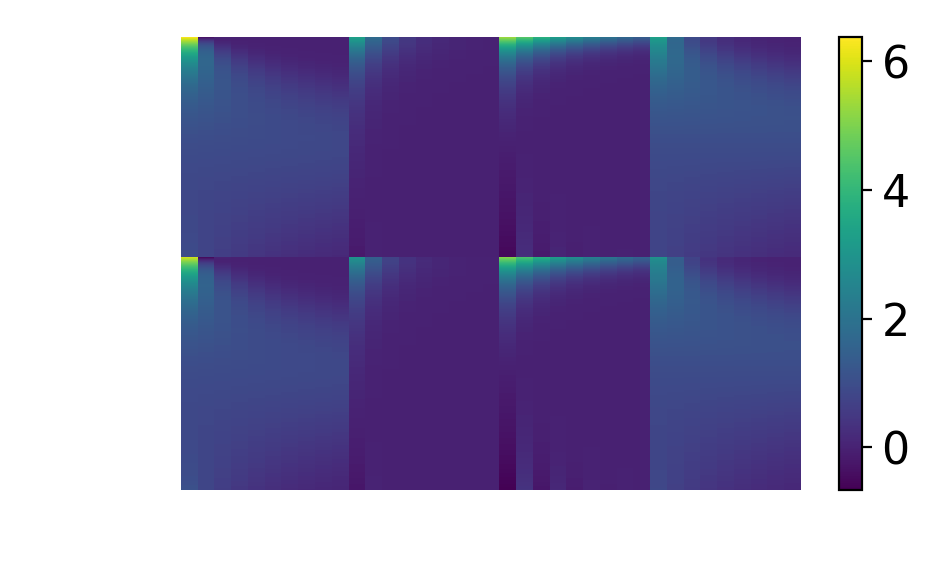

In [6]:
# The multiplicative baseline model
B_order = 10
B = np.hstack((
        np.vander(tx, N=B_order, increasing=True),
        np.vander(ty, N=B_order, increasing=True)[:, 1:],
        np.vander(tz, N=B_order, increasing=True)[:, 1:],
        np.vander(np.sqrt(tx ** 2 + ty ** 2), N=B_order, increasing=True)[:, 1:]
))

# We know that the flux *has* to be proportional
# to 1 / r^2, so we multiply that in here
B *= (1.0 / tr ** 2).reshape(-1, 1)

# Plot it
fig, ax = plt.subplots(1, figsize=(5, 3))
im = ax.imshow(B, aspect="auto")
plt.colorbar(im)
ax.axis('off');

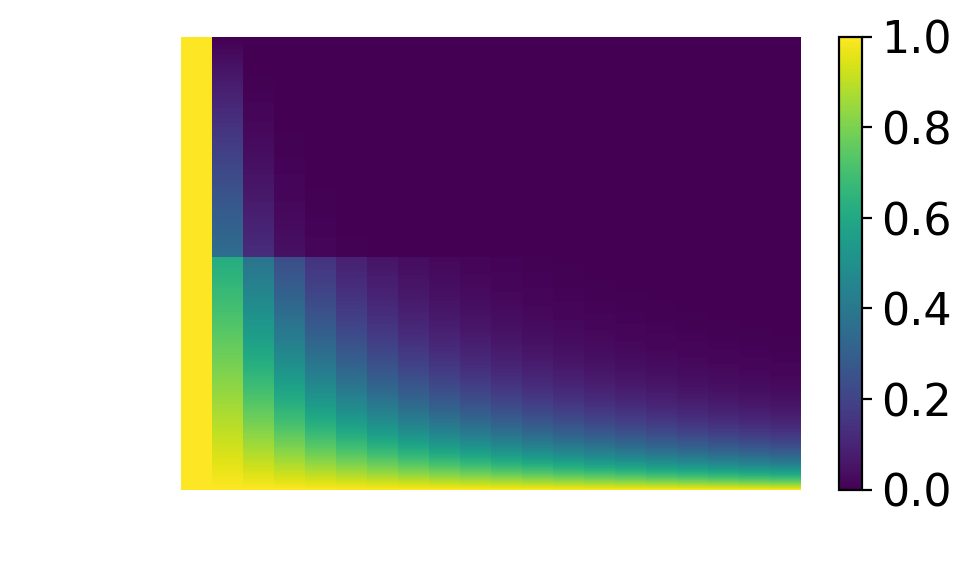

In [7]:
# The additive baseline model
C_order = 20
t = (time - time[0]) / (time[-1] - time[0])
C = np.vander(t, N=C_order, increasing=True)

# Plot it
fig, ax = plt.subplots(1, figsize=(5, 3))
im = ax.imshow(C, aspect="auto")
plt.colorbar(im)
ax.axis('off');

100%|██████████| 11363/11363 [00:04<00:00, 2630.65it/s]


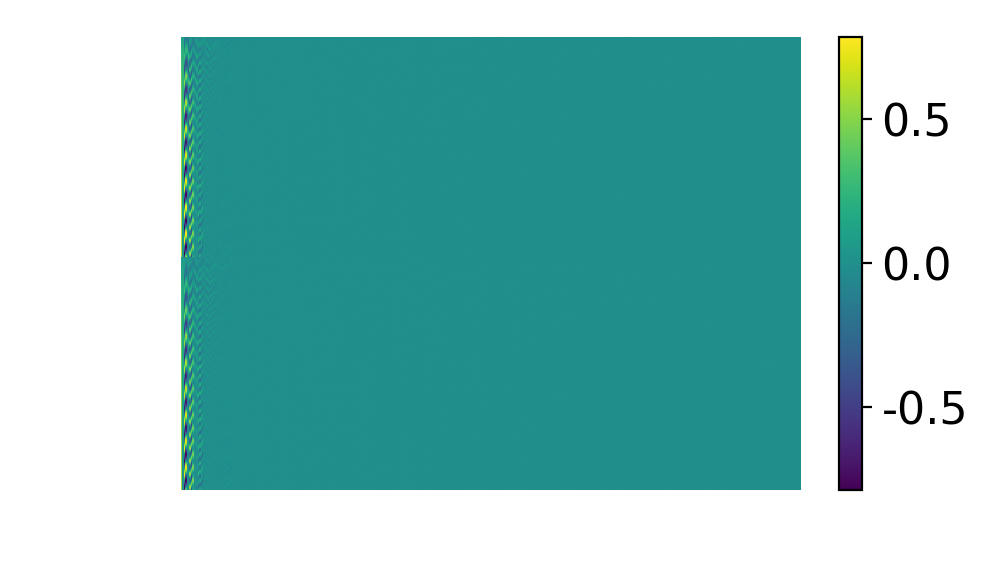

In [8]:
# The starry model
ydeg = 20
nt = 1
phase0 = 56.5 # TODO: Check this
# JD 2458325.5 = ERA 303.5 (https://dc.zah.uni-heidelberg.de/apfs/times/q/form)
ny = (ydeg + 1) ** 2

# Get the design matrix
X = earthshine.design_matrix(time, ydeg=ydeg, nt=nt, phase0=phase0, fit_linear_term=True)
    
# Plot it
fig, ax = plt.subplots(1, figsize=(5, 3))
im = ax.imshow(X, aspect="auto")
plt.colorbar(im)
ax.axis('off');

In [48]:
# Define the L2 prior on the map
def amp_l(l, a=4.25, b=0.7, c=2e-4):
    if l == 0:
        return 1
    elif l < a:
        return c * l ** b
    else:
        return c * a ** (2 * b) * l ** -b

lt = np.array([factorial(n) for n in range(nt)]) ** 2
LX = np.ones(ny * nt)
i = 0
for n in range(nt):
    amp_t = factorial(n)
    LX[i] = 10. ** 2
    i += 1
    for l in range(1, ydeg + 1):
        for m in range(-l, l + 1):
            LX[i] = (amp_l(l) * amp_t) ** 2
            i += 1

# Define the L2 prior on the multiplicative model
LB = np.ones(B.shape[1])

# Define the L2 prior on the additive model
# We are *strongly* disfavoring it
LC = 0.1 ** 2 * np.ones(C.shape[1])

In [49]:
# Initialize the three models
nc = len(time)
nl = len(flux)

Xwx = np.ones(nc)
Cwc = np.zeros(nc * nl)
Bwb = np.ones(nc * nl)

# The diagonal of the data covariance
D = flux_err.reshape(-1) ** 2

# The flattened light curves
data = flux.reshape(-1)

# The augmented starry design matrix
XBig = np.tile(X, (nl, 1))

In [50]:
# Iterate!
niter = 100
loss = np.zeros(niter)
wb = np.empty((nl, B.shape[1]))
wc = np.empty((nl, C.shape[1]))
for n in tqdm(range(niter)):
    # Compute the baseline model: one per light curve
    for i in range(nl):
        # Indices for this light curve
        l = slice(i * nc, (i + 1) * nc, 1)
        
        # Compute the multiplicative baseline
        wb[i] = starry.MAP(B, LB, D[l] / Xwx ** 2, (data[l] - Cwc[l]) / Xwx)
        Bwb[l] = np.dot(B, wb[i])

        # Compute the additive baseline
        wc[i] = starry.MAP(C, LC, D[l], data[l] - (Bwb[l] * Xwx))
        Cwc[l] = np.dot(C, wc[i])

    # Compute the starry model: shared by all light curves
    wx = starry.MAP(XBig, LX, D / Bwb ** 2, (data - Cwc) / Bwb)
    Xwx = np.dot(X, wx)
    
    # Compute the loss: reduced chi squared
    model = Bwb * np.tile(Xwx, nl) + Cwc
    loss[n] = 0.5 * np.sum(((data - model) ** 2 / D)) / (nc * nl)

100%|██████████| 100/100 [02:05<00:00,  1.21s/it]


In [51]:
np.savez("../data/syst.npz", Bwb=Bwb, Cwc=Cwc)

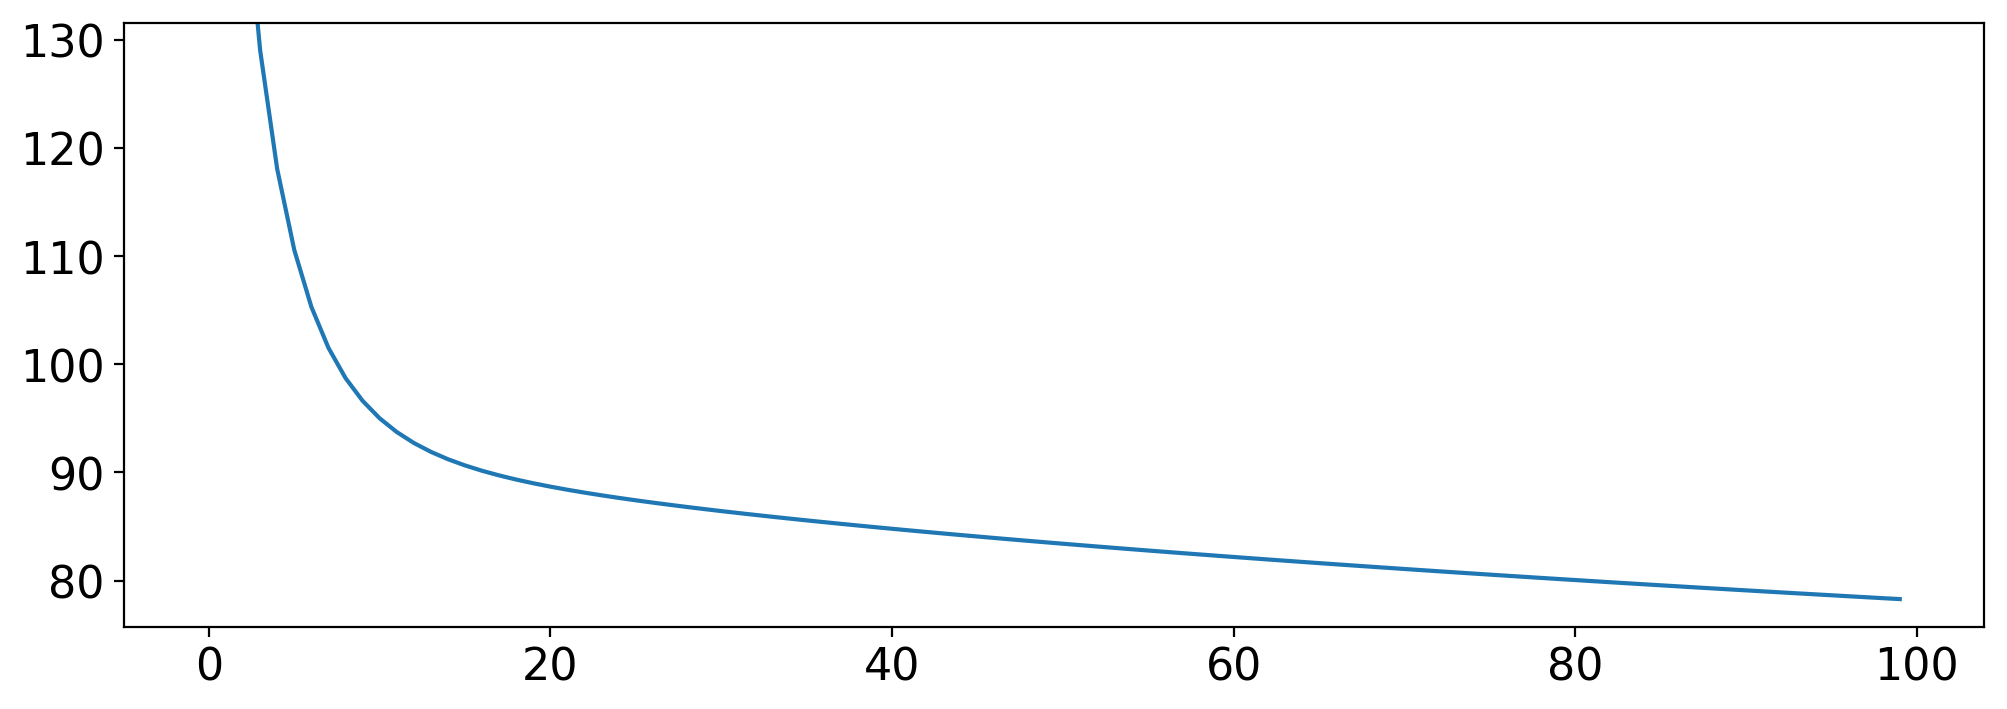

In [52]:
fig, ax = plt.subplots(1)
burn = 3
ax.plot(loss[burn:], alpha=0)
ax.set_ylim(*ax.get_ylim())
ax.plot(loss, color="C0");

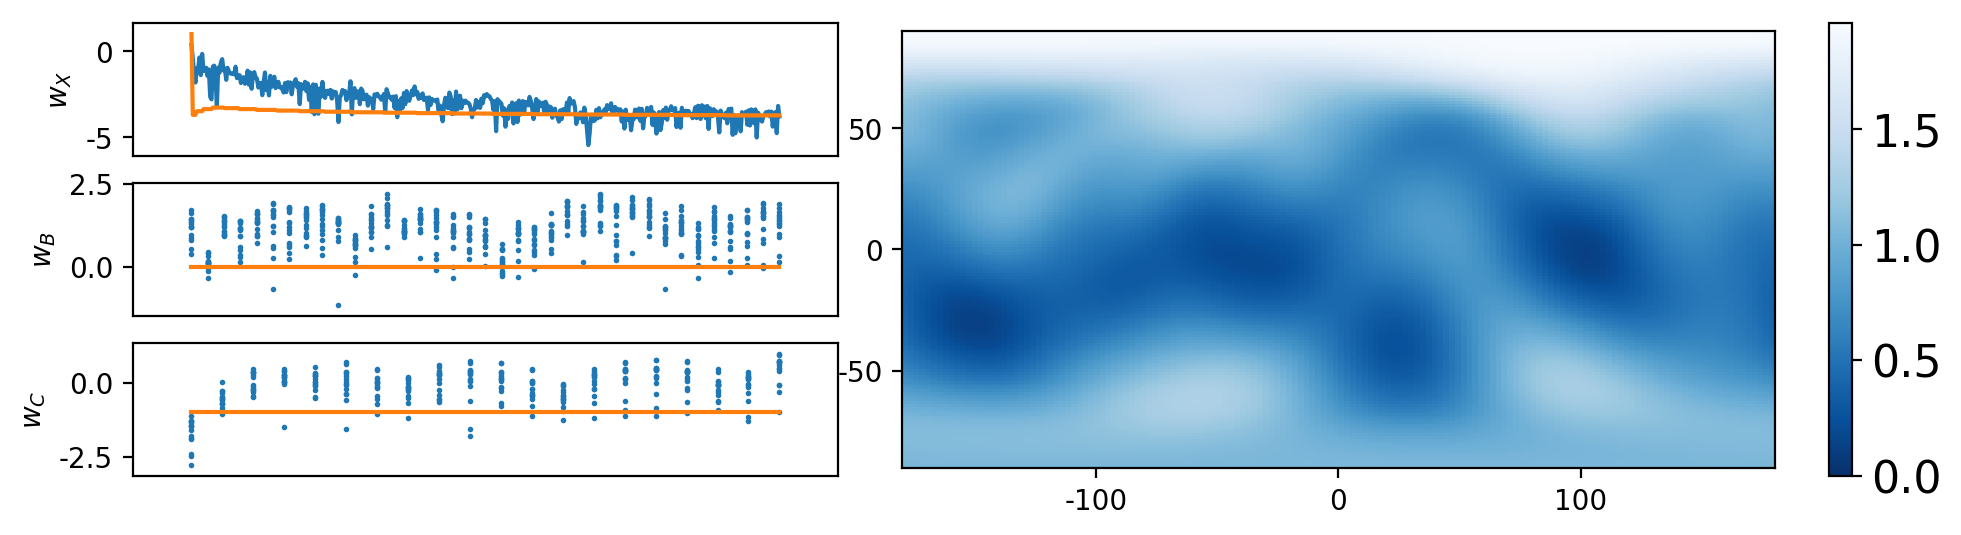

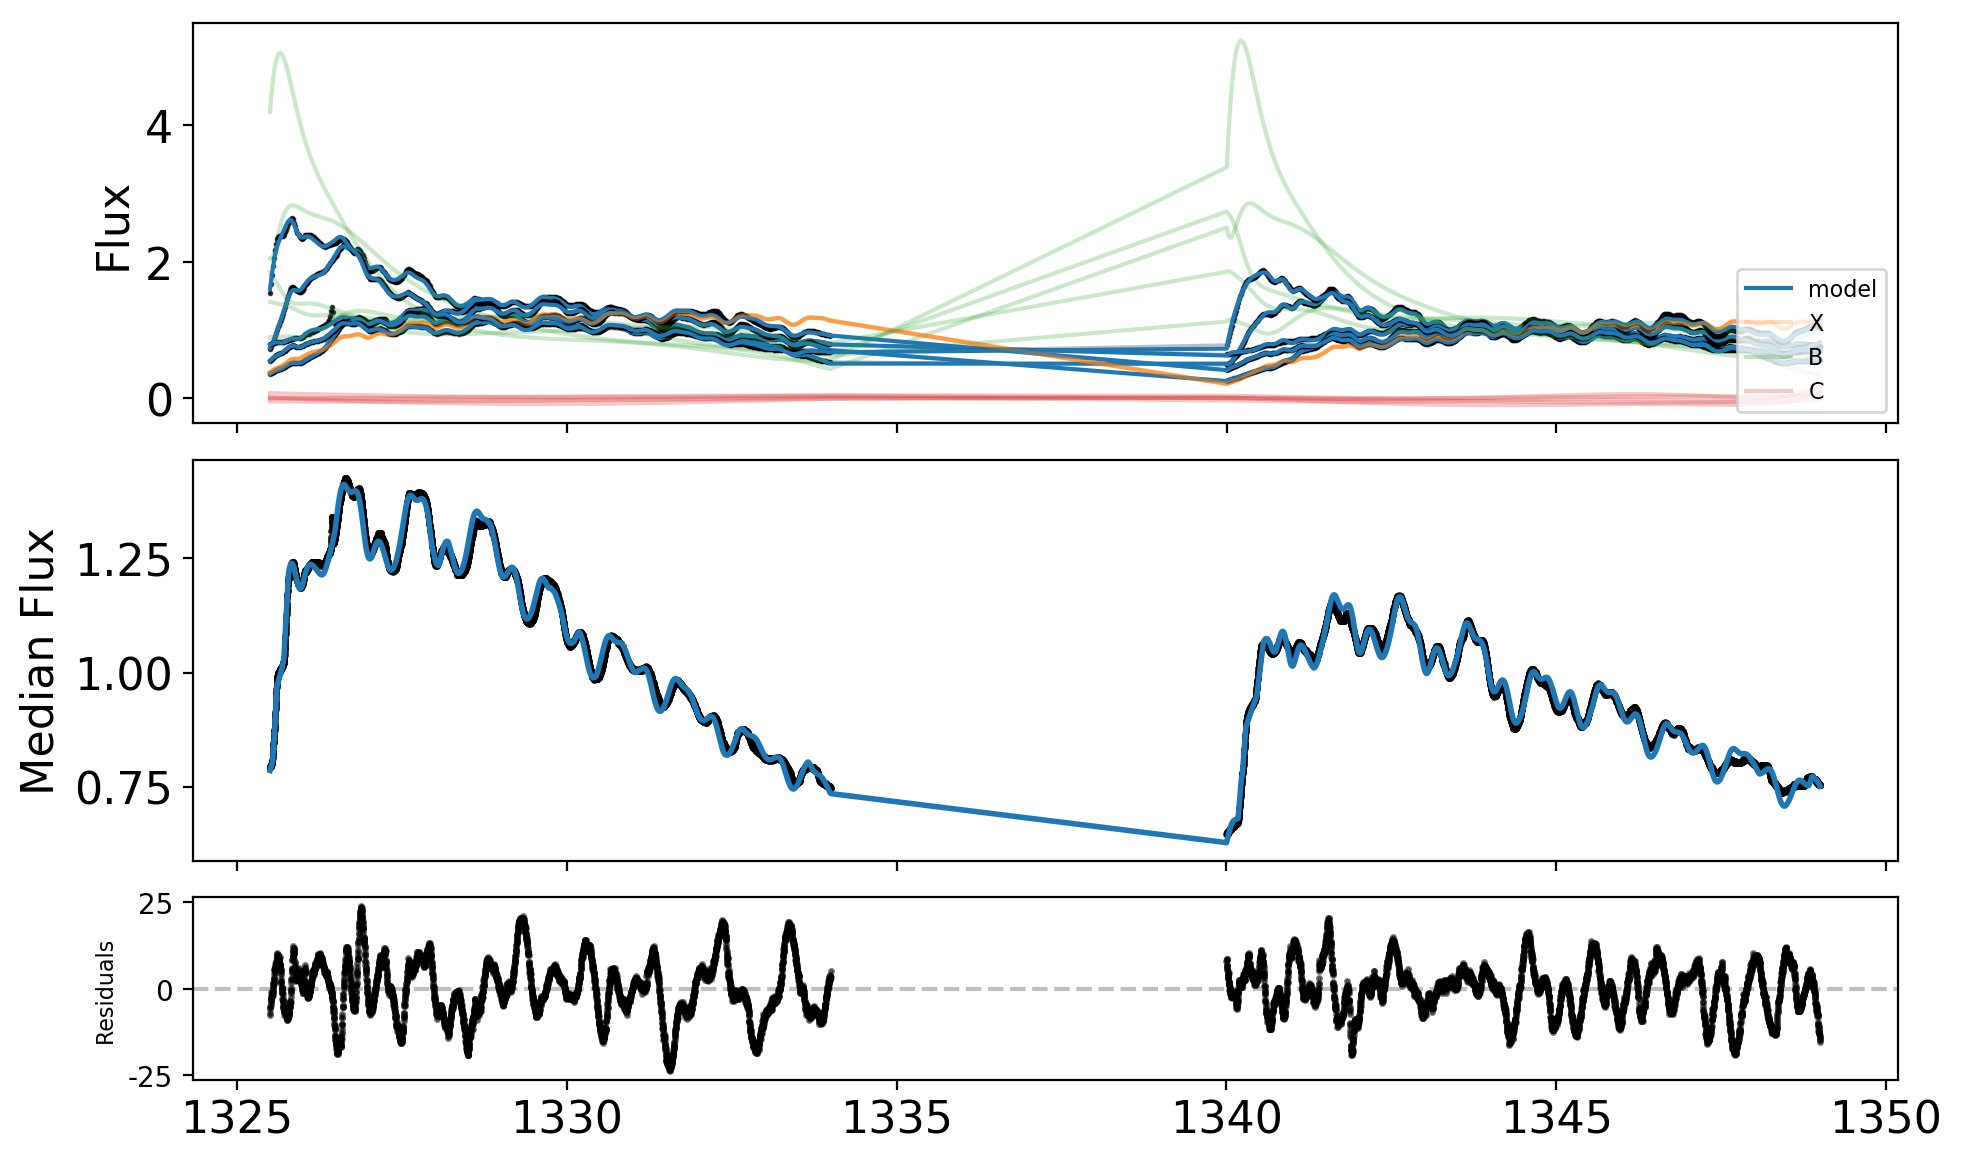

In [53]:
# Set the map coefficients
map = starry.Map(ydeg=ydeg, nt=nt, reflected=True)
for n in range(nt):
    map[:, :, n] = wx[n * ny:(n + 1) * ny]

# Plot the coefficients and the map at t = 0
fig = plt.figure(figsize=(12, 3))
ax = [plt.subplot2grid((3, 5), (0, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (1, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (2, 0), rowspan=1, colspan=2),
      plt.subplot2grid((3, 5), (0, 2), rowspan=3, colspan=3)]
for i, axis in enumerate(ax):
    for tick in axis.xaxis.get_major_ticks() + axis.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    if i < 3:
        axis.set_xticks([])
        axis.margins(0.1, 0.1)
ax[0].plot(np.log10(np.abs(wx)), '-')
ax[0].plot(np.log10(np.sqrt(LX)), '-')
ax[0].set_ylabel(r"$w_X$", fontsize=10)
for i in range(nl):
    ax[1].plot(np.log10(np.abs(wb[i])), 'C0.', ms=2)
ax[1].plot(np.log10(np.sqrt(LB)), 'C1-')
ax[1].set_ylabel(r"$w_B$", fontsize=10)
for i in range(nl):
    ax[2].plot(np.log10(np.abs(wc[i])), 'C0.', ms=2)
ax[2].plot(np.log10(np.sqrt(LC)), 'C1-')
ax[2].set_ylabel(r"$w_C$", fontsize=10)
cmap = plt.get_cmap("Blues_r")
cmap.set_under('w')  
Z = map.render(t=-1, res=150, projection="rect", source=None)[0]
vmin = 0
vmax = None #1
im = ax[3].imshow(Z, origin="lower", cmap=cmap, extent=(-180, 180, -90, 90), vmin=vmin, vmax=vmax);
fig.colorbar(im)

# Plot the data and model
thin = 10
nsamp = 5

fig = plt.figure(figsize=(11, 7))
ax = [plt.subplot2grid((5, 1), (0, 0), rowspan=2, colspan=1),
      plt.subplot2grid((5, 1), (2, 0), rowspan=2, colspan=1),
      plt.subplot2grid((5, 1), (4, 0), rowspan=1, colspan=1)]
tthin = time[::thin]
inds = np.arange(nl, dtype=int)
np.random.shuffle(inds)
inds = inds[:nsamp]
for i in inds:
    # Indices for this light curve
    l = slice(i * nc, (i + 1) * nc, 1)
    ax[0].plot(tthin, data[l][::thin], 'k.', alpha=0.75, ms=2)
    ax[0].plot(tthin, data[l][::thin], 'k-', alpha=0.25, lw=1)
    ax[0].plot(tthin, model[l][::thin], color="C0", label="model" if i == inds[0] else None);
    ax[0].plot(tthin, Xwx[::thin], color="C1", alpha=0.25, label="X" if i == inds[0] else None);
    ax[0].plot(tthin, Bwb[l][::thin], color="C2", alpha=0.25, label="B" if i == inds[0] else None);
    ax[0].plot(tthin, Cwc[l][::thin], color="C3", alpha=0.25, label="C" if i == inds[0] else None);

ax[1].plot(time, np.nanmedian([data[slice(i * nc, (i + 1) * nc, 1)] for i in range(nl)], axis=0), 'k.', alpha=0.75, ms=3)
ax[1].plot(time, np.nanmedian([model[slice(i * nc, (i + 1) * nc, 1)] for i in range(nl)], axis=0), 'C0-', lw=2)
ax[2].plot(time, np.nanmedian([((data - model) / np.sqrt(D))[slice(i * nc, (i + 1) * nc, 1)] for i in range(nl)], axis=0), 'k.', alpha=0.5, ms=3)

ax[0].set_ylabel("Flux")
ax[1].set_ylabel("Median Flux")
ax[2].set_ylabel("Residuals", fontsize=8)
ax[0].legend(fontsize=8, loc="lower right")
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].axhline(0, color="k", alpha=0.25, ls="--");
for tick in ax[2].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)

In [ ]:
drawcoastlines(linewidth=1.0, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)

In [ ]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))
ax.coastlines(resolution='1000m')

/anaconda3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/1000m/physical/ne_1000m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11be7be18> (for post_execute):


HTTPError: HTTP Error 404: Not Found